# Genetic Algorithm for SPA

https://machinelearningmastery.com/simple-genetic-algorithm-from-scratch-in-python/

In [45]:
import numpy as np
import random
from numpy.random import randint
from numpy.random import rand
import matplotlib.pyplot as plt
%matplotlib inline
import csv

End of file name for data to be fed to model

In [46]:
# fname = 'ideal' # first choice of each student uniquely ranked 1

fname = '0'     # randomly generated selection form

fname = '2020_21' # data from previous years dissertation unit 

Generate example student project selection matrix to test model 

In [47]:
with open(f'data/student_preference_matrices/student_preference_matrix_{fname}.csv', 'r') as f:
    cost_matrix = csv.reader(f)
    
    cost_matrix = [[int(i) for i in j] for j in cost_matrix]            # convert from string
    
    cost_matrix = [[10 if i==0 else i for i in j] for j in cost_matrix] # replace zeros with 10
    
    
print(np.matrix(cost_matrix))

n_students, n_projects = np.array(cost_matrix).shape

[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ...  2 10 10]
 [10 10 10 ... 10  3 10]
 [10 10 10 ... 10 10 10]]


Modify form to include projects with student capacity > 1 by creating repeat instances of the project in the form, with equal student ranking 

In [48]:
#with open('data/student_preference_matrices/project_capacity_ideal.csv', 'r') as f:
with open(f'data/student_preference_matrices/student_preference_matrix_{fname}.csv', 'r') as f:
    capacity = list(csv.reader(f))
    capacity = [int(i) for i in capacity[0]]

    
# give projects an ID so that multiple columns with the same ID can be re-grouped later 
project_ID = list(range(n_projects)) 

# temporarily include project ID and capacity vectors in cost matrix
cost_matrix.insert(0, project_ID)
cost_matrix.insert(1, capacity)


# if project capacity n > 1
for i in range(n_projects):              
    if capacity[i] > 1:
        
        # create n-1 copies of the column for that project
        # there are now n columns representing that project (with same ID number and student rank)
        for j in range(capacity[i]-1):   
            for row in cost_matrix:
                row.append(row[i])
                

# remove adn store project ID and capacity vectors 
project_ID = cost_matrix.pop(0)
capacity = cost_matrix.pop(0)
                
print(np.matrix(cost_matrix))

[[10 10 10 ...  5  5  5]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


Define an objective / fitness function to be minimised.

In [49]:
# objective function
c = random.sample(range(n_projects), k=n_students)
print(c)

def objective(x):
    """ the function to minimize """
#     count = 0
#     for i,j in enumerate(x):
#         print(cost_matrix[i][j])
#         count += cost_matrix[i][j]
#     print(count)
        
    return sum([cost_matrix[i][j]for i,j in enumerate(x)])
    
#     print(z)
    
objective(c)

[117, 277, 46, 75, 280, 159, 77, 214, 296, 70, 89, 82, 115, 233, 76, 186, 165, 122, 169, 133, 190, 44, 96, 131, 209, 113, 142, 14, 194, 79, 162, 239, 160, 74, 234, 260, 254, 257, 271, 192, 87, 110, 180, 83, 11, 38, 135, 274, 8, 40, 52, 100, 222, 252, 106, 104, 172, 34, 278, 210, 15, 223, 281, 67, 23, 147, 30, 54, 266, 208, 197, 84, 0, 202]


732

In [50]:
def selection(pop, scores, k=3):
    """
    tournament selection
    
    """
    sample_idxs = randint(0, len(pop), k)       # select k random indexes for individuals to sample
    
    sample = [scores[i] for i in sample_idxs]   # score of each individual
    
    best_sample_idx = np.argmin(sample)         # ID of best score in sample (tournament)
    
    best_pop_idx = sample_idxs[best_sample_idx] # population ID of best score in sample
    
    return best_pop_idx      # return best individual and population ID

In [51]:
def crossover(p1_ID, p2_ID, pop, scores):
    """
    Modified fusion operator.
    Crossover two parents to one child. 
    Avoids breaking constraint that each project may be assigend to only one student.
    """
    #c1, c2 = p1.copy(), p2.copy()    # children are copies of parents by default
    
    f1, f2 = scores[p1_ID], scores[p2_ID] # fitness of each parent
    
    p1, p2 = pop[p1_ID], pop[p2_ID]       # parents
    
    c = ['*' for p in p1]                 # child
    
    for i in range(len(c)):               # for each child gene, i
        
        # if neither parent 1 and parent 2 gene i already in child chromosome
        if p1[i] not in c[:i] and p2[i] not in c[:i]: 
            
            if p1[i] == p2[i]:            # if both parent genes are the same
                c[i] = p1[i]              # set child gene as same allele
                
            # otherwise choose gene from parent 1 or 2 with probability proportional to paretn fitness
            else:                         
                if rand() <= f1/(f2+f1):
                    c[i] = p1[i]
                else:
                    c[i] = p2[i]
                    
        # if both parent 1 and parent 2 gene i already in child chromosome
        elif p1[i] in c[:i] and p2[i] in c[:i]:
            
            # choose random allele not already in child chromosome
            c[i] = random.choice(list(set(range(n_projects))-set(c[:i]))) 
            
    
        # if gene i from one parent already in child chromosome use gene from other parent
        elif p1[i] in c[:i]:
            c[i] = p2[i]
            
        elif p2[i] in c[:i]:
            c[i] = p1[i]
             
    return c
                    


In [52]:
def mutation(chromosome, r_mut):
    """
    mutation operator
    """
    for i in range(len(chromosome)):
        
        if rand() < r_mut:                     # decide whether to mutate gene
            
            # exchange gene for allele not already in chromosome
            chromosome[i] = random.choice(list(set(range(n_projects))-set(chromosome)))  
            
    return chromosome

In [53]:
# genetic algorithm
def genetic_algorithm(objective, n_bits, n_iter, n_pop, r_mut):
    
    """
    Minimises objective function.
    """
    
    # initial population of random chromosomes
    # each chromosome has length n_students which each stdeunt ssigned a project number 
    pop = [random.sample(range(n_projects), k=n_students) for _ in range(n_pop)]
    
    # initiailse list to store best solution each round
    log_best = []  
    
    # initialise variables that update when new best found to track best overall solution
    best_gen, best_score, best_sol = 0, objective(pop[0]), pop[0] # track best overall solution
    
    
    for gen in range(n_iter):                    # cycle through each generation
        
        scores = [objective(c) for c in pop]     # evaluate all chromosomes in the population
        
        best_ = min(scores)                       # best chromosome in current population
        
        best_ID = np.argmin(scores)              # find its position in the list 
        
        log_best.append(best_)                    # store best solution this round
        
        if best_ < best_score:                    # if new best found, update vars and print msg
            best_gen = gen
            best_score = best_
            best_sol = pop[best_ID]          
            #print(f"Gen {gen}, best score = {best_}, chromosome = {pop[best_ID]}")
        
        # select 2 parents
        # run tournament selection n_pop times to get 2 winners as parents of new gen
        p1_ID, p2_ID = selection(pop, scores) , selection(pop, scores)
        
        c = crossover(p1_ID, p2_ID, pop, scores)  # crossover to produce 1 child
        
        c = mutation(c, r_mut)                    # mutate child
        
        """replace worst chromosome with child if the child is:
        - better than any single
        - different from all
        chomosome in the population"""        
        
        worst_ID = np.argmax(scores)              # worst chromosome in current population
        
        if objective(c) < scores[worst_ID] and c not in pop:
            pop[worst_ID] = c
        
    return log_best, best_sol

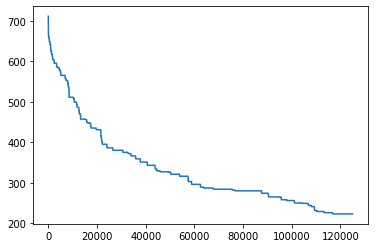

In [54]:
n_iter = 125_000                                      # total iterations

n_pop = 30                                         # population size

r_mut = 1.0 / (float(n_pop) * np.sqrt(n_students)) # mutation rate

# perform the genetic algorithm search
best_log, best_sol = genetic_algorithm(objective, n_students, n_iter, n_pop, r_mut)

plt.plot(best_log)

Display output 

In [55]:
print('student', list(range(n_students)))

# project ID of each project in best solution
allocations = [project_ID[j] for j in best_sol]
print('project allocation', allocations)

# student ranking of each project in best solution
ranks = [cost_matrix[i][j]for i,j in enumerate(best_sol)]
print('rank of allocated projects', ranks)
print('\nsum of project rankings (should be as low as possible)=', sum(ranks))

student [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
project allocation [128, 35, 242, 294, 228, 44, 116, 144, 240, 276, 278, 261, 170, 16, 107, 256, 234, 51, 223, 52, 166, 45, 216, 209, 297, 226, 231, 73, 96, 230, 72, 265, 220, 71, 206, 19, 245, 145, 164, 260, 188, 274, 266, 285, 252, 127, 296, 222, 244, 292, 255, 299, 258, 18, 49, 101, 115, 288, 286, 225, 83, 139, 137, 65, 290, 79, 76, 64, 249, 257, 61, 162, 66, 284]
rank of allocated projects [3, 4, 3, 1, 1, 10, 10, 3, 10, 1, 10, 4, 2, 3, 1, 2, 2, 1, 5, 2, 1, 1, 1, 3, 1, 4, 1, 1, 4, 2, 2, 4, 1, 2, 1, 10, 2, 4, 1, 1, 3, 3, 1, 3, 4, 10, 5, 1, 1, 4, 1, 1, 2, 2, 3, 2, 10, 1, 1, 2, 1, 1, 1, 2, 2, 1, 10, 1, 2, 2, 1, 10, 1, 3]

sum of project rankings (should be as low as possible)= 223
